# Feed Forward networks
Let's build  a simple feed forward network to classify the Fashion MNIST dataset, which relying on keras to set up the network for us. Along the way, we'll explore how to visualize the data and the network.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import collections
from tensorflow.python.framework import ops
from tensorflow.examples.tutorials.mnist import input_data

/Users/jeremyfox/dev/ml-study/tf-env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/jeremyfox/dev/ml-study/tf-env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/jeremyfox/dev/ml-study/tf-env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/jeremyfox/dev/ml-study/tf-env/lib

Let's explore the shape of the data. We need to get the dimension correct to know how to build the network.

In [2]:
# Set up a namedtuple to pass around images and labels together
DataAndLabel = collections.namedtuple("DataAndLabel", "images labels")

def images_to_vectors(images, dim = 784):
    num_images = images.shape[0]
    return np.reshape(images, (num_images, dim))

# Import fashion mnist
train, test = tf.keras.datasets.fashion_mnist.load_data()
train = DataAndLabel(images_to_vectors(train[0]), train[1])
test = DataAndLabel(images_to_vectors(test[0]), test[1])
# Shapes of training set
print("Training set (images) shape: {shape}".format(shape=train.images.shape))
print("Training set (labels) shape: {shape}".format(shape=train.labels.shape))

# Shapes of test set
print("Test set (images) shape: {shape}".format(shape=test.images.shape))
print("Test set (labels) shape: {shape}".format(shape=test.labels.shape))

# Create dictionary of target classes
label_dict = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

Training set (images) shape: (60000, 784)
Training set (labels) shape: (60000,)
Test set (images) shape: (10000, 784)
Test set (labels) shape: (10000,)


We can go ahead and visualize some examples from the dataset, so that we know what we're working with.

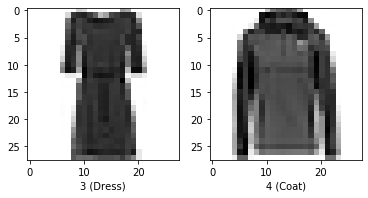

In [3]:
# Sample 1

# Get vector into 28 x 28 image format.
SAMPLE_1_INDEX = 47
sample_1 = np.reshape(train.images[SAMPLE_1_INDEX], (28, 28))
# Get corresponding integer label from one-hot encoded data
sample_label_1 = train.labels[SAMPLE_1_INDEX]
# Plot the sample
label = label_dict[sample_label_1]
plt.subplot(1, 2, 1)
plt.imshow(sample_1, cmap='Greys')
plt.xlabel(f"{sample_label_1} ({label})")

# Sample 2
# Get vector into 28 x 28 image format.
SAMPLE_2_INDEX = 24
sample_2 = np.reshape(train.images[SAMPLE_2_INDEX], (28, 28))
# Get corresponding integer label from one-hot encoded data
sample_label_2 = train.labels[SAMPLE_2_INDEX]
# Plot the sample
label = label_dict[sample_label_2]
plt.subplot(1, 2, 2)
plt.imshow(sample_2, cmap='Greys')
plt.xlabel(f"{sample_label_2} ({label})")
plt.show()

Now we can start building the network!

We will build a 3 layer feedforward network with 128 units in each hidden layer. We can use ReLU activation function for the hidden layers, and then we'll pass to a softmax function of 10 units, one for each output class.

In [4]:
# First let's set up the parameters
n_hidden_1 = 128  # Units in first hidden layer
n_hidden_2 = 128  # Units in second hidden layer
n_input = 784  # Fashion MNIST data input (img shape: 28*28)
n_classes = 10  # Fashion MNIST total classes (0–9 digits)
n_samples = train.images.shape[0]  # Number of examples in training set

# Create placeholders


def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.

    Args:
    n_x -- scalar, size of an image vector
    n_y -- scalar, number of classes

    Returns:
    X -- placeholder for the data input, of shape [x_n, None] and dtype float
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype float
    """

    X = tf.placeholder(tf.float32, [n_x, None], name="X")
    Y = tf.placeholder(tf.float32, [n_y, None], name="Y")
    return X, Y

# Initialize weights and biases for each layer. These will be
# updated during training.


def initialize_parameters():
    """
    Initializes parameters to build a neural network with tensorflow.

    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """

    # Set random seed for reproducibility
    tf.set_random_seed(42)  # Answer to life, the universe, and everything

    # Initialize weights and biases for each layer
    # First hidden layer
    W1 = tf.get_variable("W1", [n_hidden_1, n_input],
                         initializer=tf.contrib.layers.xavier_initializer(seed=42))
    b1 = tf.get_variable("b1", [n_hidden_1, 1],
                         initializer=tf.zeros_initializer())

    # Second hidden layer
    W2 = tf.get_variable("W2", [n_hidden_2, n_hidden_1],
                         initializer=tf.contrib.layers.xavier_initializer(seed=42))
    b2 = tf.get_variable("b2", [n_hidden_2, 1],
                         initializer=tf.zeros_initializer())

    # Output layer
    W3 = tf.get_variable("W3", [n_classes, n_hidden_2],
                         initializer=tf.contrib.layers.xavier_initializer(seed=42))
    b3 = tf.get_variable("b3", [n_classes, 1],
                         initializer=tf.zeros_initializer())

    # Store initializations as a dictionary of parameters
    parameters = {
        "W1": W1,
        "b1": b1,
        "W2": W2,
        "b2": b2,
        "W3": W3,
        "b3": b3
    }

    return parameters

## Forward propagation


In [5]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model:
    LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX

    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing the parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """

    # Retrieve parameters from dictionary
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']

    # Carry out forward propagation
    Z1 = tf.add(tf.matmul(W1, X), b1)
    A1 = tf.nn.relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)
    A2 = tf.nn.relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)

    return Z3

## Computing cost

We'll create a function to compute the cost based on the output from the last linear layer `Z3` and the target classes `Y`.

In [6]:
def compute_cost(Z3, Y):
    """
    Computes the cost.

    Arguments:
    Z3 -- output of forward propagation, of shape (10, number_of_examples)
    Y -- labels vector placeholder, same shape as Z3

    Returns:
    cost -- Tensor of the cost function.
    """

    # Get logits (predictions) and labels
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)

    # Compute cost
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
        logits=logits, labels=labels))

    return cost

## Batching
We're going to implement our own batching function for the time being. In the future, we can go and integrate with Tensorflow's Dataset API to use a prebuilt (and better) batching function.

In [7]:
def next_batch(num, data_and_labels):
    """
    Batching function that returns a random subset of all data.
    """
    points_to_labels = list(zip(*data_and_labels))
    index = np.arange(0, len(points_to_labels))
    np.random.shuffle(index)
    index = index[:num]
    selected = [points_to_labels[i] for i in index]
    points = [pair[0] for pair in selected]
    point_matrix = np.column_stack(points)
    # One hot encode the label data
    label_indices = np.array([pair[1] for pair in selected])
    label_matrix = np.zeros((num, 10))
    label_matrix[np.arange(num), label_indices] = 1
    return point_matrix, label_matrix.T

In [8]:
def model(train, test, learning_rate=0.0001, num_epochs=16,
          minibatch=16, minibatch_size=32, print_cost=True, graph_filename='costs'):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.

    Arguments:
    train -- training set
    test -- test set
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every epoch

    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.

    """

    # Ensure that the model can be rerun without overwriting tf variables.
    ops.reset_default_graph()
    # For reproducibility
    tf.set_random_seed(42)
    seed = 42
    # Get input and output shapes
    n_x = 784 #train.images.shape[0]
    n_y = 10 # train.labels.shape[0]
    m = 60000
    costs = []
    # Create placeholders of shape (n_x, n_y)
    X, Y = create_placeholders(n_x, n_y)
    # Initialize parameters
    parameters = initialize_parameters()
    # Forward propagation
    Z3 = forward_propagation(X, parameters)
    # Cost function
    cost = compute_cost(Z3, Y)
    # Backpropagation (using adam)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    # Initialize variables
    init = tf.global_variables_initializer()
    # Start session to compute Tensorflow graph
    with tf.Session() as sess:
        # Run initialization
        sess.run(init)
        # Training loop
        for epoch in range(num_epochs):
            epoch_cost = 0
            num_minibatches = int(m / minibatch_size)
            seed += 1
            for i in range(num_minibatches):
                # Get next batch of training data and labels
                minibatch_X, minibatch_Y = next_batch(minibatch_size, train)
                # Execute optimizer and cBost function
                _, minibatch_cost = sess.run([optimizer, cost], feed_dict={
                                             X: minibatch_X, Y: minibatch_Y})
                # Update epoch cost
                epoch_cost += minibatch_cost / num_minibatches
            # Print the cost every epoch
            if print_cost == True:
                print(f"Cost after epoch {epoch}: {epoch_cost}")
                costs.append(epoch_cost)
        # Plot costs
        plt.figure(figsize=(16, 5))
        plt.plot(np.squeeze(costs), color='#2A688B')
        plt.xlim(0, num_epochs - 1)
        plt.ylabel("cost")
        plt.xlabel("iterations")
        plt.title(f"learning rate = {learning_rate}")
        plt.show()
        # Save parameters
        parameters = sess.run(parameters)
        print("Parameters have been trained!")
        # Calculate correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))
        # Calculate accuracy on test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print("Train Accuracy:", accuracy.eval(
            {X: train.images.T, Y: train.labels.T}))
        print("Test Accuracy:", accuracy.eval(
            {X: test.images.T, Y: test.labels.T}))
        return parameters

## Running our model
Time to pass the Fashion MNIST data into the network and see how it performs

W0811 17:27:15.675818 4617024960 deprecation.py:323] From <ipython-input-6-f8dd00a6b784>:19: softmax_cross_entropy_with_logits (from tensorflow.python.ops.nn_ops) is deprecated and will be removed in a future version.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



Cost after epoch 0: 2.951427838595714
Cost after epoch 1: 0.7024880980888996
Cost after epoch 2: 0.6021261622150739
Cost after epoch 3: 0.5282117662211258
Cost after epoch 4: 0.4967819825053216
Cost after epoch 5: 0.46626583807468314
Cost after epoch 6: 0.4463427957971886
Cost after epoch 7: 0.4196726261814431
Cost after epoch 8: 0.4178341076989971
Cost after epoch 9: 0.3959736172219129
Cost after epoch 10: 0.3822738613744579
Cost after epoch 11: 0.3794506519635525
Cost after epoch 12: 0.36387255077362074
Cost after epoch 13: 0.3516101077437406
Cost after epoch 14: 0.34498947336822683
Cost after epoch 15: 0.33619209797978367


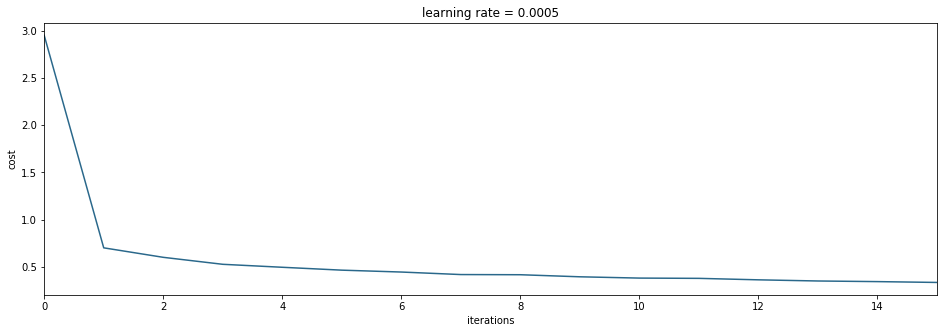

Parameters have been trained!


ValueError: Cannot feed value of shape (60000,) for Tensor 'Y:0', which has shape '(10, ?)'

In [9]:
parameters = model(train, test, learning_rate=0.0005)